In [586]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import (DateType, StringType, StructField, StructType, TimestampType, ArrayType,
                               FloatType, IntegerType, LongType)
import pyspark.sql.functions as F
from pyspark.sql import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator

from operator import add
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timedelta  


%matplotlib inline

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
spark

In [4]:
schema = StructType([
    StructField("timestamp", StringType()),
    StructField("elb", StringType()),
    StructField("client_port", StringType()),
    StructField("backend_port", StringType()),
    StructField("request_processing_time", FloatType()),
    StructField("backend_processing_time", FloatType()),
    StructField("response_processing_time", FloatType()),
    StructField("elb_status_code", IntegerType()),
    StructField("backend_status_code", IntegerType()),
    StructField("received_bytes", LongType()),
    StructField("sent_bytes", LongType()),
    StructField("request", StringType()),
    StructField("user_agent", StringType()),
    StructField("ssl_cipher", StringType()),
    StructField("ssl_protocol", StringType())
])

In [5]:
df = spark.read.csv('2015_07_22_mktplace_shop_web_log_sample.log', sep=' ', schema=schema)

In [6]:
df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- elb: string (nullable = true)
 |-- client_port: string (nullable = true)
 |-- backend_port: string (nullable = true)
 |-- request_processing_time: float (nullable = true)
 |-- backend_processing_time: float (nullable = true)
 |-- response_processing_time: float (nullable = true)
 |-- elb_status_code: integer (nullable = true)
 |-- backend_status_code: integer (nullable = true)
 |-- received_bytes: long (nullable = true)
 |-- sent_bytes: long (nullable = true)
 |-- request: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- ssl_cipher: string (nullable = true)
 |-- ssl_protocol: string (nullable = true)



In [7]:
df.where('client_port LIKE "1.186.143.37%"').show(50, False)

+---------------------------+----------------+------------------+-------------+-----------------------+-----------------------+------------------------+---------------+-------------------+--------------+----------+------------------------------------------------------------------+------------------------------------------------------------------------+---------------------------+------------+
|timestamp                  |elb             |client_port       |backend_port |request_processing_time|backend_processing_time|response_processing_time|elb_status_code|backend_status_code|received_bytes|sent_bytes|request                                                           |user_agent                                                              |ssl_cipher                 |ssl_protocol|
+---------------------------+----------------+------------------+-------------+-----------------------+-----------------------+------------------------+---------------+-------------------+--------------+-----

In [9]:
timestamp_format = "yyyy-MM-dd'T'HH:mm:ss"

def request_timestamp(time_col):
    return (F.to_timestamp(time_col, format=timestamp_format).cast('double') + \
            F.substring(time_col, -8, 7).cast('double'))

def return_timestamp(time_col):
    return request_timestamp(time_col) + \
            F.when(F.col('request_processing_time') == -1, 0.0).otherwise(F.col('request_processing_time')) + \
            F.when(F.col('backend_processing_time') == -1, 0.0).otherwise(F.col('backend_processing_time')) + \
            F.when(F.col('response_processing_time') == -1, 0.0).otherwise(F.col('response_processing_time'))

In [10]:
df_temp = df.select('timestamp',
                    request_timestamp('timestamp').alias('request_timestamp'),
                    return_timestamp('timestamp').alias('return_timestamp'),
                    F.substring_index('client_port', ':', 1).alias('client_ip'),
                    F.regexp_extract('request', r'https{0,1}:[^\s]+', 0).alias('url'))

# ,
#                (((F.unix_timestamp('timestamp', format=timestamp_format) * 1000).cast('double') + 
#                 (F.col('request_processing_time') * 1000)) / 1000).cast('timestamp').alias('gheu')
# F.expr("substring(request, instr(request, ' '), length(request))").alias('url'))
# F.substring_index()
# d1.select(F.substring('temm',1, 10)).show(50, False)
# d1.select(F.substring('temm', F.instr('temm', ' '), F.length('temm'))).show(50, False)


In [11]:
df_temp.show(5, False)

+---------------------------+-------------------+--------------------+---------------+---------------------------------------------------------------------------------------------------+
|timestamp                  |request_timestamp  |return_timestamp    |client_ip      |url                                                                                                |
+---------------------------+-------------------+--------------------+---------------+---------------------------------------------------------------------------------------------------+
|2015-07-22T09:00:28.019143Z|1.437570028019143E9|1.437570028045294E9 |123.242.248.130|https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null       |
|2015-07-22T09:00:27.894580Z|1.43757002789458E9 |1.43757002804797E9  |203.91.211.44  |https://paytm.com:443/shop/wallet/txnhistory?page_size=10&page_number=0&channel=web&version=2      |
|2015-07-22T09:00:27.885745Z|1.437570027885745E9|1.43757002805074

In [12]:
df_temp.createOrReplaceTempView('df_temp')

In [13]:
idle_time = 1800 # 15 minutes

df_sessionized = spark.sql("""
with temp as (
    select *,
    LAG(return_timestamp, 1) OVER
    (PARTITION BY client_ip ORDER BY request_timestamp) AS last_return_timestamp 
    from df_temp
),
temp2 as 
(
    select *, request_timestamp - last_return_timestamp as diff from temp
),
temp3 as 
(
    select *,
        case when diff > {idle_time} or last_return_timestamp is null then 1 else 0 end as session_start
    from temp2
)
select *,
        sum(session_start) OVER (PARTITION BY client_ip order by request_timestamp) as user_session_id
from temp3
""".format(idle_time=idle_time))

In [14]:
df_sessionized.show(50, False)

+---------------------------+-------------------+--------------------+------------+---------------------------------------------------------------------------------------------------+---------------------+--------------------+-------------+---------------+
|timestamp                  |request_timestamp  |return_timestamp    |client_ip   |url                                                                                                |last_return_timestamp|diff                |session_start|user_session_id|
+---------------------------+-------------------+--------------------+------------+---------------------------------------------------------------------------------------------------+---------------------+--------------------+-------------+---------------+
|2015-07-22T16:14:36.308131Z|1.437596076308131E9|1.4375960763127928E9|1.186.143.37|https://paytm.com:443/                                                                             |null                 |null                |1  

In [15]:
df_sessionized.createOrReplaceTempView('df_sessionized')

In [16]:
df_sessionized.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- request_timestamp: double (nullable = true)
 |-- return_timestamp: double (nullable = true)
 |-- client_ip: string (nullable = true)
 |-- url: string (nullable = true)
 |-- last_return_timestamp: double (nullable = true)
 |-- diff: double (nullable = true)
 |-- session_start: integer (nullable = false)
 |-- user_session_id: long (nullable = true)



In [431]:
df_session_with_length = spark.sql("""
        select client_ip, 
                user_session_id, 
                min(request_timestamp) as session_start_time,
                max(return_timestamp) - min(request_timestamp) as session_length
        from df_sessionized
        group by client_ip, user_session_id
""")
df_session_with_length.createOrReplaceTempView('df_session_with_length')

In [432]:
df_session_with_length.select('session_length')

+------------+---------------+-------------------+------------------+
|client_ip   |user_session_id|session_start_time |session_length    |
+------------+---------------+-------------------+------------------+
|1.186.143.37|1              |1.437596076308131E9|8.547727108001709 |
|1.187.164.29|1              |1.437547411135201E9|69.36416792869568 |
|1.22.41.76  |1              |1.43759777901417E9 |62.31779098510742 |
|1.23.208.26 |1              |1.437601301431398E9|1145.6662831306458|
|1.23.36.184 |1              |1.437556464807342E9|14.42006778717041 |
+------------+---------------+-------------------+------------------+
only showing top 5 rows



In [430]:
df_sessionized.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- request_timestamp: double (nullable = true)
 |-- return_timestamp: double (nullable = true)
 |-- client_ip: string (nullable = true)
 |-- url: string (nullable = true)
 |-- last_return_timestamp: double (nullable = true)
 |-- diff: double (nullable = true)
 |-- session_start: integer (nullable = false)
 |-- user_session_id: long (nullable = true)



Average session time

In [18]:
spark.sql("""
    select avg(session_length) from df_session_with_length
""").show(1, False)

+-------------------+
|avg(session_length)|
+-------------------+
|164.0693588680101  |
+-------------------+



Most engaged users

In [19]:
spark.sql("""
        with temp as (
            select client_ip, 
                    avg(session_length) as max_session 
            from df_session_with_length
            group by client_ip
        )
        select client_ip from temp order by max_session desc
""").show(5, False)

+--------------+
|client_ip     |
+--------------+
|103.29.159.138|
|125.16.218.194|
|14.99.226.79  |
|117.217.94.18 |
|117.218.61.172|
+--------------+
only showing top 5 rows



Unique URL visits per session

In [20]:
spark.sql("""
        select client_ip, 
                user_session_id, 
        count(distinct url) as url_count
        from df_sessionized
        group by client_ip, user_session_id
""").show(5, False)

+------------+---------------+---------+
|client_ip   |user_session_id|url_count|
+------------+---------------+---------+
|1.186.143.37|1              |2        |
|1.187.164.29|1              |8        |
|1.22.41.76  |1              |5        |
|1.23.208.26 |1              |6        |
|1.23.36.184 |1              |4        |
+------------+---------------+---------+
only showing top 5 rows



In [21]:
df_sessionized.select(F.to_timestamp('request_timestamp')).show(5, False)

+---------------------------------+
|to_timestamp(`request_timestamp`)|
+---------------------------------+
|2015-07-22 09:00:28.019143       |
|2015-07-22 09:00:27.89458        |
|2015-07-22 09:00:27.885745       |
|2015-07-22 09:00:28.048369       |
|2015-07-22 09:00:28.036251       |
+---------------------------------+
only showing top 5 rows



In [24]:
spark.sql("""
    select to_timestamp(timestamp, "yyyy-MM-dd'T'HH:mm:ss") from df_temp
""").show(5, False)

+------------------------------------------------------------+
|to_timestamp(df_temp.`timestamp`, 'yyyy-MM-dd\'T\'HH:mm:ss')|
+------------------------------------------------------------+
|2015-07-22 09:00:28                                         |
|2015-07-22 09:00:27                                         |
|2015-07-22 09:00:27                                         |
|2015-07-22 09:00:28                                         |
|2015-07-22 09:00:28                                         |
+------------------------------------------------------------+
only showing top 5 rows



In [623]:
df_features_raw = spark.sql("""
        select to_timestamp(timestamp, "yyyy-MM-dd'T'HH:mm") as timestamp_upto_minute,
                count(1) as request_count
        from df_temp
        group by 1
""")
df_features_raw.createOrReplaceTempView('df_features_raw')

In [630]:
min_max_time = df_features_raw.agg(F.min(F.to_timestamp('timestamp_upto_minute')), 
                                  F.max(F.to_timestamp('timestamp_upto_minute'))).collect()

times = []
time = min_max_time[0][0]
while time <= min_max_time[0][1]:
    times.append(time)
    time = time + timedelta(minutes=1)  
    
all_minutes = spark.createDataFrame(times, TimestampType())
all_minutes.createOrReplaceTempView('all_minutes')

df_features_raw = spark.sql("""
    select to_timestamp(am.value) as timestamp_upto_minute,  
            coalesce(fr.request_count, 0) as request_count
    from all_minutes am
        left join df_features_raw fr
        on fr.timestamp_upto_minute = to_timestamp(am.value)
    order by 1
""")

### Predict using weighted average and exponentially moving average

In [644]:
def weighted_average(c, window, offsets, weights):
    assert len(weights) == len(offsets)

    def value(i):
        if i < 0: return F.lag(c, -i).over(window)
        if i > 0: return F.lead(c, i).over(window)
        return c

    # Create a list of Columns
    # - `value_i * weight_i` if `value_i IS NOT NULL` 
    # - literal 0 otherwise
    values = [F.coalesce(value(i) * w, F.lit(0)) for i, w in zip(offsets, weights)]

    # or sum(values, lit(0))
    return reduce(add, values, F.lit(0))

def exponentially_moving_average(row_number, column_partition_values, window_size=5):
    smooth_factor = 2.0 / (window_size + 1)

    numerator = 0.0
    nominator = 0.0

    for i in range(row_number): 
        current_factor = math.pow(1 - smooth_factor, len(column_partition_values) - i - 1)         
        numerator = numerator + current_factor * column_partition_values[i]
        nominator = nominator + current_factor

    return numerator/nominator

exponentially_moving_average_udf = F.udf(exponentially_moving_average, FloatType())

In [651]:
window_request = Window.orderBy('timestamp_upto_minute')

offsets, delays =  [-5, -4, -3, -2, -1], [.05, .05, .2, .2, 0.5]

df_prediction_wma = df_features_raw.withColumn('next_minute_predicted_load', weighted_average(
    F.col('request_count'), window_request, offsets, delays
))

df_prediction_wma_pd = df_prediction_wma.select('next_minute_predicted_load').toPandas()

In [659]:
df_prediction_ema = df_features_raw.withColumn('row_nr', F.row_number().over(window_request)) \
                        .withColumn('next_minute_predicted_load', 
                                    exponentially_moving_average_udf(F.col('row_nr'), 
                                                                     F.collect_list('request_count') \
                                                                      .over(window_request)))

df_prediction_ema_pd = df_prediction_ema.select('next_minute_predicted_load').toPandas()

In [662]:
actual_request_count = df_features_raw.select('request_count').toPandas()

In [663]:
r2_score(actual_request_count.values, df_prediction_ema_pd.values)

0.739741809413078

In [665]:
r2_score(actual_request_count.values, df_prediction_wma_pd.values)

0.4972582686505911

### Linear Regression in Spark

In [686]:
window_size = 5
df_features_reg = df_features_raw.select(*[F.lag('request_count', i) \
                                            .over(window_request).alias('prev_request_count_{}'.format(i)) 
                                           for i in range(1, window_size + 1)], 'request_count')
reg_input_columns = ['prev_request_count_{}'.format(i) for i in range(1, window_size + 1)]

In [706]:
vectorAssembler = VectorAssembler(inputCols = reg_input_columns, 
                                  outputCol = 'features')

# encoder = OneHotEncoderEstimator(inputCols=[ 'month', 'day', 'week_day', 'hour', 'minute'],
#                                  outputCols=['month_vec', 'day_vec', 'week_day_vec', 'hour_vec', 'minute_vec'])
# model = encoder.fit(df_features.dropna())
# encoded = model.transform(df_features.dropna())

vdf_features_reg = vectorAssembler.transform(df_features_reg.dropna())
vdf_features_reg = vdf_features_reg.select(['features', 'request_count'])
# vdf_features.show(3, False)
vdf_features_reg.show(3, False)

+------------------------------------+-------------+
|features                            |request_count|
+------------------------------------+-------------+
|[4680.0,4734.0,5586.0,6787.0,4681.0]|323          |
|[323.0,4680.0,4734.0,5586.0,6787.0] |0            |
|[0.0,323.0,4680.0,4734.0,5586.0]    |0            |
+------------------------------------+-------------+
only showing top 3 rows



In [703]:
splits = vdf_features_reg.randomSplit([0.7, 0.3], seed=1)
train_df_reg = splits[0]
test_df_reg = splits[1]

In [690]:
lr = LinearRegression(featuresCol = 'features', labelCol='request_count', maxIter=100, 
                      regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df_reg)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.2172212117620642,-0.4332475188416352,0.26794654697985737,-0.5309461594159032,0.2942995053374071]
Intercept: 185.94379463364305


In [ ]:
trainScore = mean_absolute_error(trainY, trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY, testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

In [691]:
trainingSummary = lr_model.summary
print("MAE: %f" % trainingSummary.meanAbsoluteError)
print("r2: %f" % trainingSummary.r2)

MAE: 664.033459
r2: 0.785865


In [692]:
train_df.describe().show()

+-------+-----------------+
|summary|    request_count|
+-------+-----------------+
|  count|               80|
|   mean|       10272.3875|
| stddev|9112.037586320926|
|    min|                1|
|    max|            24841|
+-------+-----------------+



In [696]:
lr_predictions = lr_model.transform(test_df_reg)
# lr_predictions.select("prediction", "request_count", "features").show(5, False)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="request_count",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.783014


In [713]:
df_predictions_reg = lr_model.transform(test_df_reg)
df_prediction_reg_pd = df_predictions_reg.select('prediction').toPandas()

In [716]:
r2_score(test_df_reg.select('request_count').toPandas().values, df_prediction_reg_pd.values)

0.7830137915068395

In [718]:
test_score_reg = mean_absolute_error(test_df_reg.select('request_count').toPandas().values, df_prediction_reg_pd.values)
print('Test Score: %.2f MAE' % (test_score_reg))

Test Score: 718.00 MAE


### Predict with LSTM

In [751]:
df_features_lstm_pd = df_features_raw.select('request_count').toPandas()
df_features_lstm_pd['request_count'] = df_features_lstm_pd['request_count'].astype('double')

In [533]:
# resampled = df_features_pd.set_index('timestamp_upto_minute').resample('Min').first()
# fill = resampled.fillna(0.0).rolling(3, min_periods=1).mean()
# resampled = resampled.fillna(fill)
# resampled= resampled.fillna(0)

In [722]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [734]:
def predict_with_lstm(data, look_back=6, batch_size=1, normalize=True):
    def pre_process(data, nomrmalize):       
        train_size = int(len(data) * 0.7)
        test_size = len(data) - train_size
        train, test = data[0:train_size], data[train_size:len(resampled)]
        train, test = train.values, test.values

        if normalize:
            scaler = MinMaxScaler(feature_range=(0, 1))
            train = scaler.fit_transform(train)
            test = scaler.transform(test)
        return train, test
    
    def fit_model(trainX, trainY, look_back, batch_size):
        model = Sequential()
        model.add(layers.LSTM(32, input_shape=(None, look_back)))
        model.add(layers.Dense(1))
        model.compile(loss='mean_absolute_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=20, batch_size=batch_size)
        
    train, test = pre_process(data, normalize)   
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
    # create and fit the LSTM network
    fit_model(trainX, trainY, look_back, batch_size)
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    if normalize:
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])[0]
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])[0]
    
    trainScore = mean_absolute_error(trainY, trainPredict[:,0])
    print('Train Score: %.2f MAE' % (trainScore))
    testScore = mean_absolute_error(testY, testPredict[:,0])
    print('Test Score: %.2f MAE' % (testScore))
    
    return trainY, testY, trainPredict, testPredict

def plot_original(data):
    figure = plt.figure(figsize=(15, 6))
    plt.plot(data)
    plt.xlabel('Timesteps (minutes)')
    plt.ylabel('Load (Requests per minute)')
    plt.title('Original Request Load Trend')
    plt.show()
    
def plot_predictions(data, trainPredict, testPredict, look_back=6, normalized=False):
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(resampled)-1, :] = testPredict
    # plot baseline and predictions
    figure = plt.figure(figsize=(15, 6))
    plt.plot(trainPredictPlot, label='Training')
    plt.plot(testPredictPlot, label='Testing')
    plt.xlabel('Timesteps (minutes)')
    plt.ylabel('Load (Requests per minute)')
    plt.title('Predicted Request Load Trend')
    plt.legend()
    plt.show()

In [747]:
trainPredictPlot.shape

(1111, 1)

In [737]:
train_y_lstm, test_y_lstm, train_predict_lstm, test_predict_lstm = \
        predict_with_lstm(df_features_lstm_pd, look_back=6, batch_size=1, normalize=True)

/Users/asifiqbal/Development/anaconda/anaconda3/envs/asif_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/20
770/770 [==============================] - 7s 10ms/step - loss: 0.0299
Epoch 2/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0212
Epoch 3/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0183
Epoch 4/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0168
Epoch 5/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0155
Epoch 6/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0153
Epoch 7/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0150
Epoch 8/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0150
Epoch 9/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0147
Epoch 10/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0142
Epoch 11/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0145
Epoch 12/20
770/770 [==============================] - 2s 3ms/step - loss: 0.0144
Epoch 13/20
770/770 [===

In [738]:
r2_score(test_y_lstm, test_predict_lstm)

0.8495564620888152

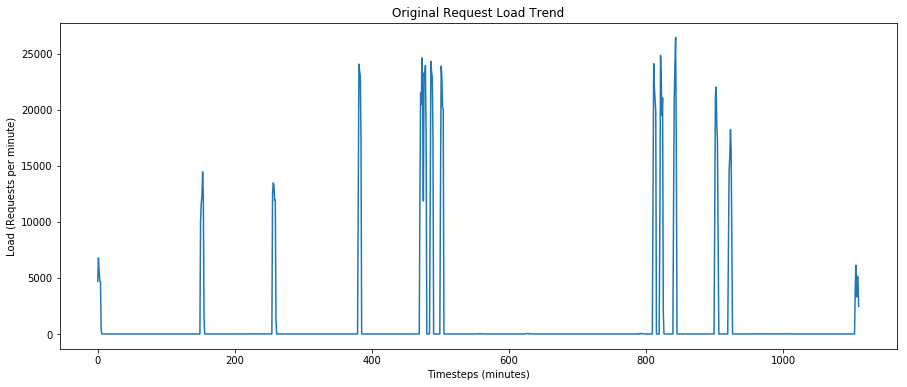

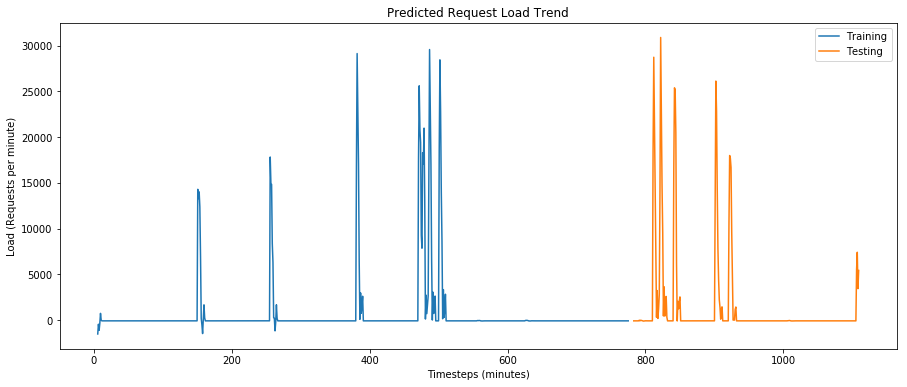

In [753]:
plot_original(df_features_lstm_pd.values)
# plot_predictions()
plot_predictions(df_features_lstm_pd.values, train_predict_lstm, test_predict_lstm)

### Predict session length for a Given IP

In [479]:
window = Window.partitionBy('client_ip').orderBy('session_start_time')#.rowsBetween(-5, -5)

In [446]:
df_session_with_length.withColumn("moving_length", F.avg(('session_length')).over(window)) \
    .show(5, False)

+------------+---------------+-------------------+------------------+------------------+
|client_ip   |user_session_id|session_start_time |session_length    |moving_length     |
+------------+---------------+-------------------+------------------+------------------+
|1.186.143.37|1              |1.437596076308131E9|8.547727108001709 |8.547727108001709 |
|1.187.164.29|1              |1.437547411135201E9|69.36416792869568 |69.36416792869568 |
|1.22.41.76  |1              |1.43759777901417E9 |62.31779098510742 |62.31779098510742 |
|1.23.208.26 |1              |1.437601301431398E9|1145.6662831306458|1145.6662831306458|
|1.23.36.184 |1              |1.437556464807342E9|14.42006778717041 |14.42006778717041 |
+------------+---------------+-------------------+------------------+------------------+
only showing top 5 rows



In [495]:
offsets, delays =  [-4, -3, -2, -1, 0], [.1, .1, .2, .2, 0.4]

df_session_with_length.withColumn('next_session_predicted_length', weighted_average(
    F.col("session_length"), window, offsets, delays
)).show(5, False)

+------------+---------------+-------------------+------------------+-----------------------------+
|client_ip   |user_session_id|session_start_time |session_length    |next_session_predicted_length|
+------------+---------------+-------------------+------------------+-----------------------------+
|1.186.143.37|1              |1.437596076308131E9|8.547727108001709 |3.4190908432006837           |
|1.187.164.29|1              |1.437547411135201E9|69.36416792869568 |27.745667171478274           |
|1.22.41.76  |1              |1.43759777901417E9 |62.31779098510742 |24.92711639404297            |
|1.23.208.26 |1              |1.437601301431398E9|1145.6662831306458|458.26651325225833           |
|1.23.36.184 |1              |1.437556464807342E9|14.42006778717041 |5.768027114868165            |
+------------+---------------+-------------------+------------------+-----------------------------+
only showing top 5 rows



In [497]:
spark.sql("""
    select client_ip, count(distinct user_session_id)
    from df_session_with_length
    group by 1
    order by 2 desc
    limit 5
""").show(5, False)

+--------------+-------------------------------+
|client_ip     |count(DISTINCT user_session_id)|
+--------------+-------------------------------+
|220.226.206.7 |11                             |
|185.20.4.220  |8                              |
|54.251.31.140 |8                              |
|207.46.13.22  |8                              |
|117.239.35.226|8                              |
+--------------+-------------------------------+



In [614]:
all_minutes = spark.createDataFrame(times, TimestampType())
all_minutes.createOrReplaceTempView('all_minutes')